# Setup

The implementation is given by: https://keras.io/examples/vision/image_classification_with_vision_transformer/

In [1]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.6 MB/s eta 0:00:00


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.optimizers import SGD, Adam
from tensorflow_addons.optimizers import AdamW
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import pickle

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Prepare the data

In [6]:
dataset_dir = r"C:\Users\User\OneDrive - Univerzitet u Novom Sadu\Desktop\HyperKvasir\hyper-kvasir-final"

In [7]:
def get_dataCategories(dataset_dir):
    import glob

    categories = []
    for folder_name in os.listdir(dataset_dir):
        if os.path.isdir(os.path.join(dataset_dir, folder_name)):
            nbr_files = len(
                glob.glob(os.path.join(dataset_dir, folder_name) + "/*.jpg")
            )
            categories.append(np.array([folder_name, nbr_files]))

    categories.sort(key=lambda a: a[0])
    cat = np.array(categories)

    return list(cat[:, 0]), list(cat[:, 1])

categories, nbr_files = get_dataCategories(dataset_dir)

# Create DataFrame
df = pd.DataFrame({"categorie": categories, "numbre of files": nbr_files})
print("number of categories: ", len(categories))
df

number of categories:  23


,categorie,numbre of files
0,barretts,41
1,barretts-short-segment,53
2,bbps-0-1,646
3,bbps-2-3,1148
4,cecum,1009
5,dyed-lifted-polyps,1002
6,dyed-resection-margins,989
7,esophagitis-a,403
8,esophagitis-b-d,260
9,hemorrhoids,6


## Obtaining the entire data and labels

In [8]:
def get_x_y(datadir, categories, img_wid, img_high):
    X, y = [], []
    for category in categories:
        path = os.path.join(datadir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                ima_resize_rgb = cv2.resize(img_array, (img_wid, img_high))

                X.append(ima_resize_rgb)
                y.append(class_num)

            except Exception as e:
                print(e)

    y = np.array(y)
    X = np.array(X)

    # reshape X into img_wid x img_high x 3
    X = X.reshape(X.shape[0], img_wid, img_high, 3)

    return X, y


img_wid, img_high = 224, 224
X, y = get_x_y(dataset_dir, categories, img_wid, img_high)

print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (10662, 224, 224, 3)
y: (10662,)


## Visualize the data

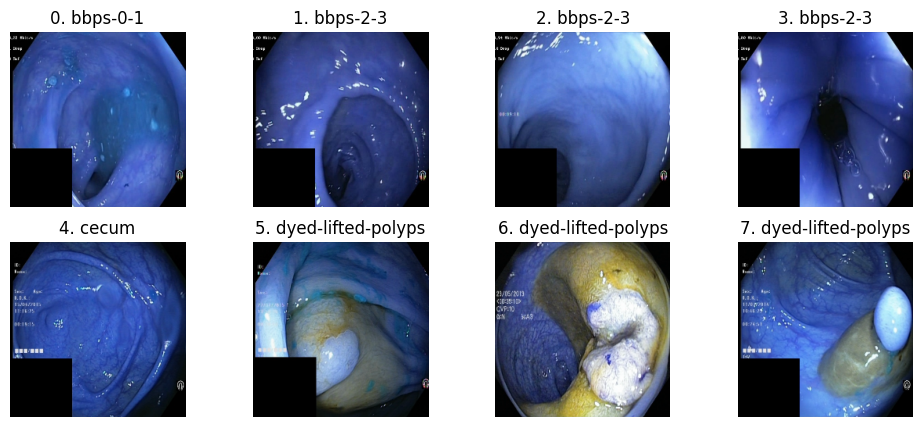

In [9]:
plt.figure(figsize=(12, 5))
st, end = 0, 500
for i in range(8):
    plt.subplot(2, 4, i + 1)
    idx = np.random.randint(st, end)
    st = end + 1
    end = (i + 2) * 500
    plt.imshow(X[idx][:, :, ::-1])
    plt.title(f"{i}. {categories[y[idx]]}")
    plt.axis("off")
plt.show()

## Split the data into train and test

In [11]:
Y = np.reshape(y, (len(y), 1))


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, train_size=0.8, random_state=42
)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (8529, 224, 224, 3)
y_train: (8529, 1)
X_test: (2133, 224, 224, 3)
y_test: (2133, 1)


# Data augmentation

In [12]:
# Data augmentation

image_size = 224

data_augmentation = keras.Sequential(
    [
        keras.layers.Normalization(),
        keras.layers.Resizing(image_size, image_size),
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(factor=0.02),
        keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

# Building the ViT model

#Model diagram
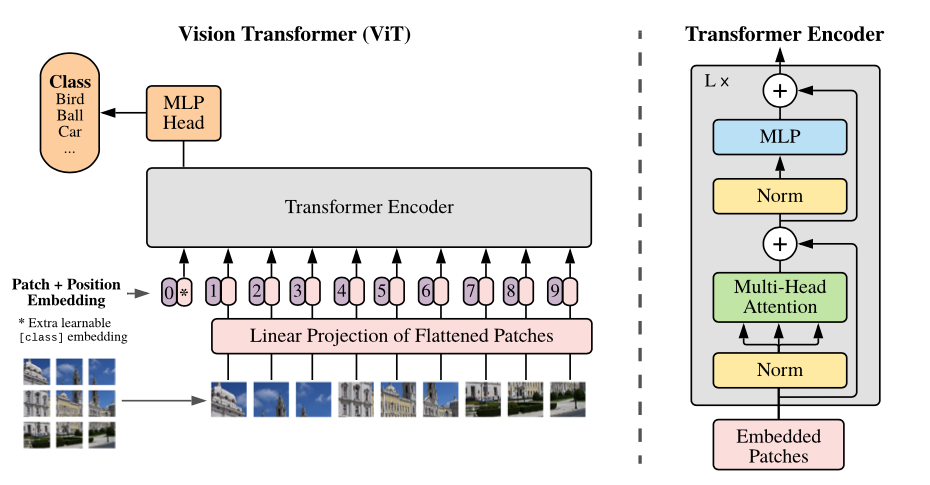

## Multi-Layer-Perceptron (MLP)

In [26]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Patch creation layer

In [32]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


## Hyper-parameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 250
image_size = 224  # We'll resize input images to this size
patch_size = 12  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

(-0.5, 223.5, 223.5, -0.5)

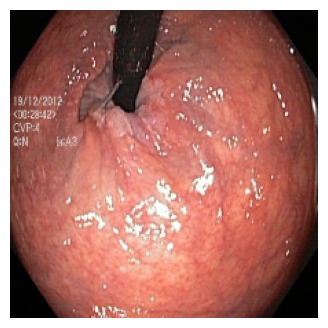

In [34]:
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

Image size: 224 X 224
Patch size: 12 X 12
Patches per image: 324
Elements per patch: 432


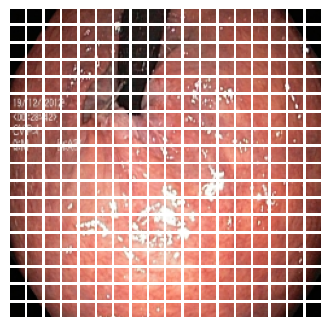

In [35]:
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Patch encoding layer

In [36]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


# Final ViT model

In [37]:
num_classes = 23
input_shape = (224, 224, 3)

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


# Run the experiment

In [38]:
gpu = len(tf.config.list_physical_devices('GPU')) > 0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is NOT AVAILABLE


In [39]:
model = create_vit_classifier()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 224, 224, 3)  7          ['input_1[0][0]']                
                                                                                                  
 patches_4 (Patches)            (None, None, 432)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 324, 64)      48448       ['patches_4[0][0]']          

In [ ]:
def run_experiment(model):
    optimizer = AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_model_name = "model_1-" + datetime.now().strftime("%d-%m-%Y-%H-%M-%S") + ".h5"
    checkpoint_filepath = f"C:/Users/User/OneDrive - Univerzitet u Novom Sadu/Desktop/HyperKvasir/proba/{checkpoint_model_name}"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )


    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")


    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")


Epoch 1/250
30/30 [==============================] - 1375s 46s/step - loss: 3.6526 - accuracy: 0.3260 - top-5-accuracy: 0.7388 - val_loss: 1.4474 - val_accuracy: 0.5721 - val_top-5-accuracy: 0.9402
Epoch 2/250
30/30 [==============================] - 1381s 46s/step - loss: 1.6251 - accuracy: 0.4898 - top-5-accuracy: 0.9028 - val_loss: 1.2031 - val_accuracy: 0.6225 - val_top-5-accuracy: 0.9648
Epoch 3/250
18/30 [=================>............] - ETA: 11:05 - loss: 1.3492 - accuracy: 0.5566 - top-5-accuracy: 0.9336